In [1]:
import pandas as pd
df = pd.read_csv('AZ_cleaned.csv') #, index_col = 0) this line removes the index column but messes with other columns, see change log
df #print(df.head(10)) for the time being, we can have it just as 'df' but I don't think that works in normal jupyter notebook?

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (4,16,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration,road_number,milepost,consent_search,vehicle_type,ethnicity
0,AZ-2009-001,AZ,2009-01-06,NaN,NaN,Maricopa County,4013.0,I10 165 NA,NaN,M,...,False,Warning,False,5283,NaN,I10,165.0,False,12PU 2007,H
1,AZ-2009-002,AZ,2009-01-18,NaN,NaN,Maricopa County,4013.0,US60 185 NA,NaN,M,...,False,Warning,False,5283,NaN,US60,185.0,False,4DSD 2004,W
2,AZ-2009-003,AZ,2009-01-20,NaN,NaN,Maricopa County,4013.0,SR202 16 NA,NaN,M,...,False,Warning,False,5283,NaN,SR202,16.0,False,4DSD 2001,H
3,AZ-2009-004,AZ,2009-01-24,NaN,NaN,Maricopa County,4013.0,US60 172.4 NA,NaN,F,...,False,Citation,False,5283,NaN,US60,172.4,False,4DSD 2003,H
4,AZ-2009-005,AZ,2009-01-25,NaN,NaN,Maricopa County,4013.0,US60 181 NA,NaN,F,...,False,Warning,False,5283,NaN,US60,181.0,False,4DSD 2001,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251987,AZ-2015-450515,AZ,2015-11-30,23:48,7.0,Maricopa County,4013.0,I17 202 NA,NaN,M,...,False,Warning,False,7460,0-10,I17,202.0,False,CP 1994,H
2251988,AZ-2015-450516,AZ,2015-11-30,23:50,3.0,Coconino County,4005.0,US89 434 NA,NaN,F,...,False,Citation,False,7829,NaN,US89,434.0,False,12PU 2005,N
2251989,AZ-2015-450517,AZ,2015-11-30,23:53,7.0,Maricopa County,4013.0,I17 202.9 NA,NaN,M,...,False,Warning,False,7460,NaN,I17,202.9,False,4DSD 2015,B
2251990,AZ-2015-450518,AZ,2015-11-30,23:56,7.0,Maricopa County,4013.0,NA NA 7THAVE/JEFFERSON,NaN,M,...,False,Citation,False,7833,NaN,NaN,NaN,False,34PU 2006,H


In [2]:
column_names = []
for col in df:
    column_names.append(col)

print(column_names)

['id', 'state', 'stop_date', 'stop_time', 'location_raw', 'county_name', 'county_fips', 'fine_grained_location', 'police_department', 'driver_gender', 'driver_age_raw', 'driver_age', 'driver_race_raw', 'driver_race', 'violation_raw', 'violation', 'search_conducted', 'search_type_raw', 'search_type', 'contraband_found', 'stop_outcome', 'is_arrested', 'officer_id', 'stop_duration', 'road_number', 'milepost', 'consent_search', 'vehicle_type', 'ethnicity']


In [3]:
#removing any columns missing values, or having NaN in the 'stop_outcome' column
df.dropna(how = 'any', subset = ['stop_outcome', 'driver_race'], axis = 0, inplace = True)
df #removes ca. 200 rows, not much, but not doing this will result in problems in the future.

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location,police_department,driver_gender,...,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration,road_number,milepost,consent_search,vehicle_type,ethnicity
0,AZ-2009-001,AZ,2009-01-06,NaN,NaN,Maricopa County,4013.0,I10 165 NA,NaN,M,...,False,Warning,False,5283,NaN,I10,165.0,False,12PU 2007,H
1,AZ-2009-002,AZ,2009-01-18,NaN,NaN,Maricopa County,4013.0,US60 185 NA,NaN,M,...,False,Warning,False,5283,NaN,US60,185.0,False,4DSD 2004,W
2,AZ-2009-003,AZ,2009-01-20,NaN,NaN,Maricopa County,4013.0,SR202 16 NA,NaN,M,...,False,Warning,False,5283,NaN,SR202,16.0,False,4DSD 2001,H
3,AZ-2009-004,AZ,2009-01-24,NaN,NaN,Maricopa County,4013.0,US60 172.4 NA,NaN,F,...,False,Citation,False,5283,NaN,US60,172.4,False,4DSD 2003,H
4,AZ-2009-005,AZ,2009-01-25,NaN,NaN,Maricopa County,4013.0,US60 181 NA,NaN,F,...,False,Warning,False,5283,NaN,US60,181.0,False,4DSD 2001,W
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2251987,AZ-2015-450515,AZ,2015-11-30,23:48,7.0,Maricopa County,4013.0,I17 202 NA,NaN,M,...,False,Warning,False,7460,0-10,I17,202.0,False,CP 1994,H
2251988,AZ-2015-450516,AZ,2015-11-30,23:50,3.0,Coconino County,4005.0,US89 434 NA,NaN,F,...,False,Citation,False,7829,NaN,US89,434.0,False,12PU 2005,N
2251989,AZ-2015-450517,AZ,2015-11-30,23:53,7.0,Maricopa County,4013.0,I17 202.9 NA,NaN,M,...,False,Warning,False,7460,NaN,I17,202.9,False,4DSD 2015,B
2251990,AZ-2015-450518,AZ,2015-11-30,23:56,7.0,Maricopa County,4013.0,NA NA 7THAVE/JEFFERSON,NaN,M,...,False,Citation,False,7833,NaN,NaN,NaN,False,34PU 2006,H


In [4]:
#df = df.rename_axis('id').rename_axis('id', axis='columns') 
""" if having used the index_col = 0 function when importing, this sets the otherwise blank name 
of the 'id' column to be 'id' however the system does not actually read it's name as 'id'. 
No solution found thus far. """
#df

" if having used the index_col = 0 function when importing, this sets the otherwise blank name \nof the 'id' column to be 'id' however the system does not actually read it's name as 'id'. \nNo solution found thus far. "

In [5]:
def remove_redundancies(df_name):
    redundant_columns = ['id','state', 'stop_date', 'location_raw', 'county_name', 'county_fips', 'fine_grained_location', 
    'driver_age_raw', 'driver_race_raw', 'violation_raw', 'search_type_raw', 'officer_id', 'stop_duration', 'road_number',
    'milepost','vehicle_type', 'police_department', 'stop_time', 'driver_age'] #note: stop time is temporarily removed because the current code doesnt want to read it properly
    df_name = df.drop(columns = redundant_columns, axis = 1, inplace = True)   #note 2: driver_age can be included if values are present in your dataset
    return df_name

remove_redundancies(df)


In [6]:
df

,driver_gender,driver_race,violation,search_conducted,search_type,contraband_found,stop_outcome,is_arrested,consent_search,ethnicity
0,M,Hispanic,NaN,False,NaN,False,Warning,False,False,H
1,M,White,NaN,False,NaN,False,Warning,False,False,W
2,M,Hispanic,NaN,False,NaN,False,Warning,False,False,H
3,F,Hispanic,License,False,NaN,False,Citation,False,False,H
4,F,White,NaN,False,NaN,False,Warning,False,False,W
...,...,...,...,...,...,...,...,...,...,...
2251987,M,Hispanic,NaN,False,NaN,False,Warning,False,False,H
2251988,F,Other,NaN,False,NaN,False,Citation,False,False,N
2251989,M,Black,NaN,False,NaN,False,Warning,False,False,B
2251990,M,Hispanic,NaN,False,NaN,False,Citation,False,False,H


In [30]:
print(df.value_counts(df['driver_race']))

driver_race
White       1346725
Hispanic     576512
Other        148054
Black        128578
Asian         51913
dtype: int64


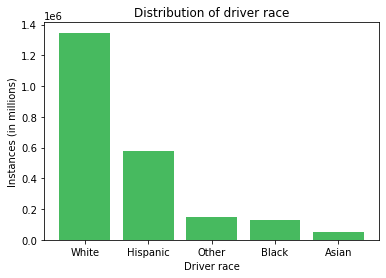

In [29]:
import numpy as np
import matplotlib.pyplot as plt
 
height = df.value_counts(df['driver_race'])
bars = ('White','Hispanic','Other','Black','Asian')
x_pos = np.arange(len(bars))
 
plt.bar(x_pos, height, color = (0.2,0.7,0.3,0.9))

plt.title('Distribution of driver race')
plt.xlabel('Driver race')
plt.ylabel('Instances (in millions)')
 
plt.xticks(x_pos, bars)  #Create names on the x axis
 
plt.show()

In [9]:
""" from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings

X = df.drop(['stop_outcome'], axis = 1)
y = df['stop_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

Xd = pd.get_dummies(X, columns = ['driver_gender', 'driver_race','violation', 'search_conducted', 'search_type', 
                                  'contraband_found', 'is_arrested', 'consent_search', 'ethnicity'])
print(Xd.shape[1] - X.shape[1], 'columns added') """

" from sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import RandomForestClassifier\nimport warnings\n\nX = df.drop(['stop_outcome'], axis = 1)\ny = df['stop_outcome']\n\nX_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)\n\nXd = pd.get_dummies(X, columns = ['driver_gender', 'driver_race','violation', 'search_conducted', 'search_type', \n                                  'contraband_found', 'is_arrested', 'consent_search', 'ethnicity'])\nprint(Xd.shape[1] - X.shape[1], 'columns added') "

In [10]:
df_testing = df.head(100000)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import warnings

X = df_testing.drop(['stop_outcome'], axis = 1)
y = df_testing['stop_outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

Xd = pd.get_dummies(X, columns = ['driver_gender', 'driver_race','violation', 'search_conducted', 'search_type', 
                                  'contraband_found', 'is_arrested', 'consent_search', 'ethnicity'])
print(Xd.shape[1] - X.shape[1], 'columns added')

263 columns added


In [11]:
Xd.dropna(axis = 0, inplace = True)
Xd

,driver_gender_F,driver_gender_M,driver_race_Asian,driver_race_Black,driver_race_Hispanic,driver_race_Other,driver_race_White,violation_DUI,"violation_DUI,Equipment","violation_DUI,Equipment,License",...,is_arrested_True,consent_search_False,consent_search_True,ethnicity_A,ethnicity_B,ethnicity_H,ethnicity_M,ethnicity_N,ethnicity_W,ethnicity_X
0,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
2,0,1,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100025,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
100026,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
100027,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
100028,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [12]:
X_train, X_test, y_train, y_test = train_test_split(Xd, y, random_state = 0)

rforest = RandomForestClassifier(max_depth = 50, random_state = 0) #possible parameters :max_depth, min_sample_split, max_leaf_nodes
                                                            #min_samples_leaf, n_estimators, max_sample (bootstrap sample), max_features

rforest.fit(X_train, y_train)
train_score = rforest.score(X_train, y_train)
test_score = rforest.score(X_test, y_test)

print('Train   Test')
print('{:.3f} {:7.3f}'.format(train_score, test_score)) #unsure if these results are correct, is there a way to make it faster?

Train   Test
0.847   0.844


Parameter size   Train   Test
       1         0.534   0.538
       5         0.558   0.562
      10         0.781   0.784
      25         0.838   0.839
      50         0.847   0.844
     100         0.851   0.847


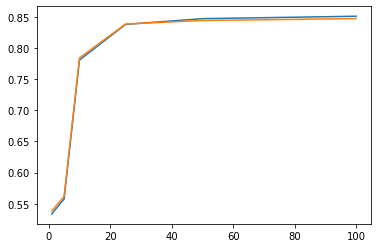

In [31]:
import matplotlib.pyplot as plt

def specific_parameters():
        user_inputs = []
        parameters = ['max_depth', 'min_sample_split', 'max_leaf_nodes', 'min_samples_leaf', 'n_estimators', 'max_sample', 'max_features']
        for item in parameters:
            user_input = input(f'Please select a value for the parameter {item}:')
            if user_input.type() != 'float':
                user_inputs.append('None')
            else:
                user_inputs.append(user_input)
        return user_inputs

def test_parameter():
    number = [1, 5, 10, 25, 50, 100]
    print('Parameter size   Train   Test')
    results_train = []
    results_test = []
    for i in number:
        rforest = RandomForestClassifier(max_depth = i, random_state = 0)
        rforest.fit(X_train, y_train)

        #TRAIN
        train_score = rforest.score(X_train, y_train)
        results_train.append(train_score)
        
        #TEST
        test_score = rforest.score(X_test, y_test)
        results_test.append(test_score)

        print('{:8d} {:13.3f} {:7.3f}'.format(i, train_score, test_score))

    x = number
    y = results_train
    plt.plot(x,y)
    y = results_test 
    plt.plot(x,y)

test_parameter() #note --> random grid can be used to optimize finding the best feature values

In [14]:
#import os
#os.system('say "Program finished"') you can insert this code after the block above if you wish to have a sound play once it's done so
                                    #don't have to sit and wait the 34 minutes it takes. 